# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Deosa Putra Caniago
- **Email:** deozaofficial@gmail.com
- **ID Dicoding:** Hid30

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("TensorFlow.js version:", tfjs.__version__)
print("All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


TensorFlow version: 2.18.0
TensorFlow.js version: 4.22.0
All packages imported successfully!


## Data Preparation

### Data Loading

In [2]:
from google.colab import files
import os
import zipfile # Import the zipfile module

# Upload dataset
uploaded = files.upload()
for fn in uploaded.keys():
    print(f"Saving {fn} to {fn}")

# Ekstrak dataset
dataset_zip = 'flowers.zip'
dataset_dir = '/dataset'
extracted_dir = os.path.join(dataset_dir, 'flowers')

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Extracted {dataset_zip} to {dataset_dir}")

# Verifikasi dataset
if os.path.exists(extracted_dir):
    print(f"Dataset found at {extracted_dir}")
    for class_name in os.listdir(extracted_dir):
        class_dir = os.path.join(extracted_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class: {class_name}, Images: {num_images}")
else:
    print(f"Dataset not found at {extracted_dir}")

Saving flowers.zip to flowers.zip
Saving flowers.zip to flowers.zip
Extracted flowers.zip to /dataset
Dataset found at /dataset/flowers
Class: dandelion, Images: 1052
Class: rose, Images: 784
Class: tulip, Images: 984
Class: daisy, Images: 764
Class: sunflower, Images: 733


### Data Preprocessing

#### Split Dataset

In [3]:
# Cell 4: Data Preprocessing with Train/Val/Test Split (No Leakage)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import hashlib
from collections import defaultdict

# Path dataset
dataset_dir = '/dataset/flowers'
target_dir = '/content/flowers'

# Cek dataset sumber
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} not found!")

# Cek struktur dataset
classes = ['dandelion', 'rose', 'tulip', 'daisy', 'sunflower']
for cls in classes:
    if not os.path.exists(f'{dataset_dir}/{cls}'):
        raise FileNotFoundError(f"Class directory {dataset_dir}/{cls} not found!")

# Hapus folder target kalau ada
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Kumpulin semua file unik
file_hashes = defaultdict(list)
all_files = []
for cls in classes:
    for f in os.listdir(f'{dataset_dir}/{cls}'):
        if f.endswith('.jpg') or f.endswith('.png'):
            src = f'{dataset_dir}/{cls}/{f}'
            with open(src, 'rb') as file:
                file_hash = hashlib.md5(file.read()).hexdigest()
            if not file_hashes[file_hash]:  # Ambil file unik
                file_hashes[file_hash].append(f'{cls}/{f}')
                all_files.append((cls, f))

# Shuffle file
random.shuffle(all_files)

# Hitung split
total = len(all_files)
train_count = int(0.8 * total)
val_count = int(0.1 * total)
test_count = total - train_count - val_count

# Bikin folder train, val, test
for split in ['train', 'validation', 'test']:
    for cls in classes:
        os.makedirs(f'{target_dir}/{split}/{cls}', exist_ok=True)

# Copy file ke split
for i, (cls, f) in enumerate(all_files):
    src = f'{dataset_dir}/{cls}/{f}'
    if i < train_count:
        dst = f'{target_dir}/train/{cls}/{f}'
    elif i < train_count + val_count:
        dst = f'{target_dir}/validation/{cls}/{f}'
    else:
        dst = f'{target_dir}/test/{cls}/{f}'
    shutil.copy(src, dst)

# Cek jumlah file
print("Jumlah file setelah split:")
for split in ['train', 'validation', 'test']:
    for cls in classes:
        count = len(os.listdir(f'{target_dir}/{split}/{cls}'))
        print(f'{split}/{cls}: {count} images')

# Cek overlap
file_hashes = defaultdict(list)
for split in ['train', 'validation', 'test']:
    for cls in classes:
        for f in os.listdir(f'{target_dir}/{split}/{cls}'):
            if f.endswith('.jpg') or f.endswith('.png'):
                with open(f'{target_dir}/{split}/{cls}/{f}', 'rb') as file:
                    file_hash = hashlib.md5(file.read()).hexdigest()
                    file_hashes[file_hash].append(f'{split}/{cls}/{f}')
overlap = 0
for file_hash, files in file_hashes.items():
    if len(files) > 1:
        overlap += len(files) - 1
        print(f"Overlap: {files}")
print(f"Total overlap: {overlap}")

# Path untuk preprocessing
train_dir = f'{target_dir}/train'
val_dir = f'{target_dir}/validation'
test_dir = f'{target_dir}/test'

# Cek direktori
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Train directory {train_dir} not found!")
if not os.path.exists(val_dir):
    raise FileNotFoundError(f"Validation directory {val_dir} not found!")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory {test_dir} not found!")

# Data generator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=8,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(96, 96),
    batch_size=8,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=8,
    class_mode='categorical'
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cek jumlah data
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Jumlah file setelah split:
train/dandelion: 841 images
train/rose: 645 images
train/tulip: 771 images
train/daisy: 617 images
train/sunflower: 574 images
validation/dandelion: 102 images
validation/rose: 67 images
validation/tulip: 112 images
validation/daisy: 67 images
validation/sunflower: 83 images
test/dandelion: 109 images
test/rose: 72 images
test/tulip: 97 images
test/daisy: 80 images
test/sunflower: 74 images
Total overlap: 0
Found 3448 images belonging to 5 classes.
Found 431 images belonging to 5 classes.
Found 432 images belonging to 5 classes.
Train samples: 3448
Validation samples: 431
Test samples: 432


## Check Data Leakage

In [4]:
def get_image_names(directory):
    images = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images.extend([os.path.basename(img) for img in os.listdir(class_dir)])
    return set(images)

train_images = get_image_names(train_dir)
val_images = get_image_names(val_dir)
test_images = get_image_names(test_dir)
print(f"Train-Val overlap: {len(train_images & val_images)}")
print(f"Train-Test overlap: {len(train_images & test_images)}")
print(f"Val-Test overlap: {len(val_images & test_images)}")

Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0


## Modelling

In [5]:
# Cell 6: Model Definition and Training (Unfreeze 30 Layers, Epoch 35)
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
import time
import os

# Membangun model
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Unfreeze 30 layer terakhir untuk fine-tuning
base_model.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

model = models.Sequential([
    layers.Input(shape=(96, 96, 3)),
    base_model,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    '/content/flower_models/model_best25.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * float(np.exp(-0.1))
    else:
        return 1e-5

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

class SaveEveryNEpochs(Callback):
    def __init__(self, save_path, n_epochs=5):
        super().__init__()
        self.save_path = save_path
        self.n_epochs = n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n_epochs == 0:
            os.makedirs(self.save_path, exist_ok=True)
            self.model.save(f"{self.save_path}/model_epoch_{epoch+1}.keras")

callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint,
    lr_scheduler_callback,
    SaveEveryNEpochs(save_path='/content/flower_models', n_epochs=5)
]

# Hitung class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Hitung jumlah batch (batch size 8)
train_generator.batch_size = 8
val_generator.batch_size = 8
test_generator.batch_size = 8
train_batches = int(np.ceil(train_generator.samples / train_generator.batch_size))  # ~431
val_batches = int(np.ceil(val_generator.samples / val_generator.batch_size))      # ~54
test_batches = int(np.ceil(test_generator.samples / test_generator.batch_size))    # ~54
print(f"Train batches per epoch: {train_batches}")
print(f"Validation batches per epoch: {val_batches}")
print(f"Test batches per epoch: {test_batches}")

# Konversi generator ke tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 96, 96, 3], [None, 5])
).take(train_batches).repeat().cache().prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 96, 96, 3], [None, 5])
).take(val_batches).cache().prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 96, 96, 3], [None, 5])
).take(test_batches).cache().prefetch(tf.data.AUTOTUNE)

# Callback untuk waktu
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch + 1} time: {self.times[-1] / 60:.2f} minutes")

time_callback = TimeHistory()
callbacks.append(time_callback)

# Train model
start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    steps_per_epoch=train_batches
)
total_time = (time.time() - start_time) / 60
print(f"Total waktu pelatihan: {total_time:.2f} menit")
print(f"Rata-rata waktu per epoch: {total_time / len(history.epoch):.2f} menit")

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_batches)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 3, 3, 16)       │       184,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,445,141 (9.33 MB)

 Trainable params: 1,713,557 (6.54 MB)

 Non-trainable params: 731,584 (2.79 MB)

Class weights: {0: np.float64(1.1176661264181524), 1: np.float64(0.8199762187871581), 2: np.float64(1.0691472868217053), 3: np.float64(1.2013937282229965), 4: np.float64(0.8944228274967575)}
Train batches per epoch: 431
Validation batches per epoch: 54
Test batches per epoch: 54
Epoch 1/35
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4572 - loss: 1.6222

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 1 time: 1.26 minutes
431/431 ━━━━━━━━━━━━━━━━━━━━ 76s 143ms/step - accuracy: 0.4574 - loss: 1.6218 - val_accuracy: 0.3828 - val_loss: 1.4871 - learning_rate: 0.0010
Epoch 2/35
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6365 - loss: 1.0681Epoch 2 time: 1.32 minutes
431/431 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step - accuracy: 0.6365 - loss: 1.0681 - val_accuracy: 0.2575 - val_loss: 1.7636 - learning_rate: 0.0010
Epoch 3/35
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7219 - loss: 0.8640Epoch 3 time: 0.94 minutes
431/431 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - accuracy: 0.7219 - loss: 0.8639 - val_accuracy: 0.5568 - val_loss: 1.4436 - learning_rate: 0.0010
Epoch 4/35
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7791 - loss: 0.7175Epoch 4 time: 0.95 minutes
431/431 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - accuracy: 0.7791 - loss: 0.7175 - val_accuracy: 0.7401 - val_loss: 1.1860 - learning_rate: 0.0010
Epoch 5/35
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step -

## Evaluasi dan Visualisasi

Cek isi folder test:
daisy  dandelion  rose	sunflower  tulip
Model loaded from /content/flower_models/model_best25.keras
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Found 432 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8699 - loss: 0.4888
Test Accuracy: 0.8565, Test Loss: 0.5693
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step

Confusion Matrix:
[[70  3  4  2  1]
 [ 7 91  2  9  0]
 [ 5  2 63  0  2]
 [ 1  5  1 66  1]
 [ 4  2  6  5 80]]

Classification Report:
              precision    recall  f1-score   support

       daisy       0.80      0.88      0.84        80
   dandelion       0.88      0.83      0.86       109
        rose       0.83      0.88      0.85        72
   sunflower       0.80      0.89      0.85        74
       tulip       0.95      0.82      0.88        97

    accuracy                           0.86       432
   macro avg       0.85      0.86      0.86       432
weighted avg       0.86      0.86      0.86       432



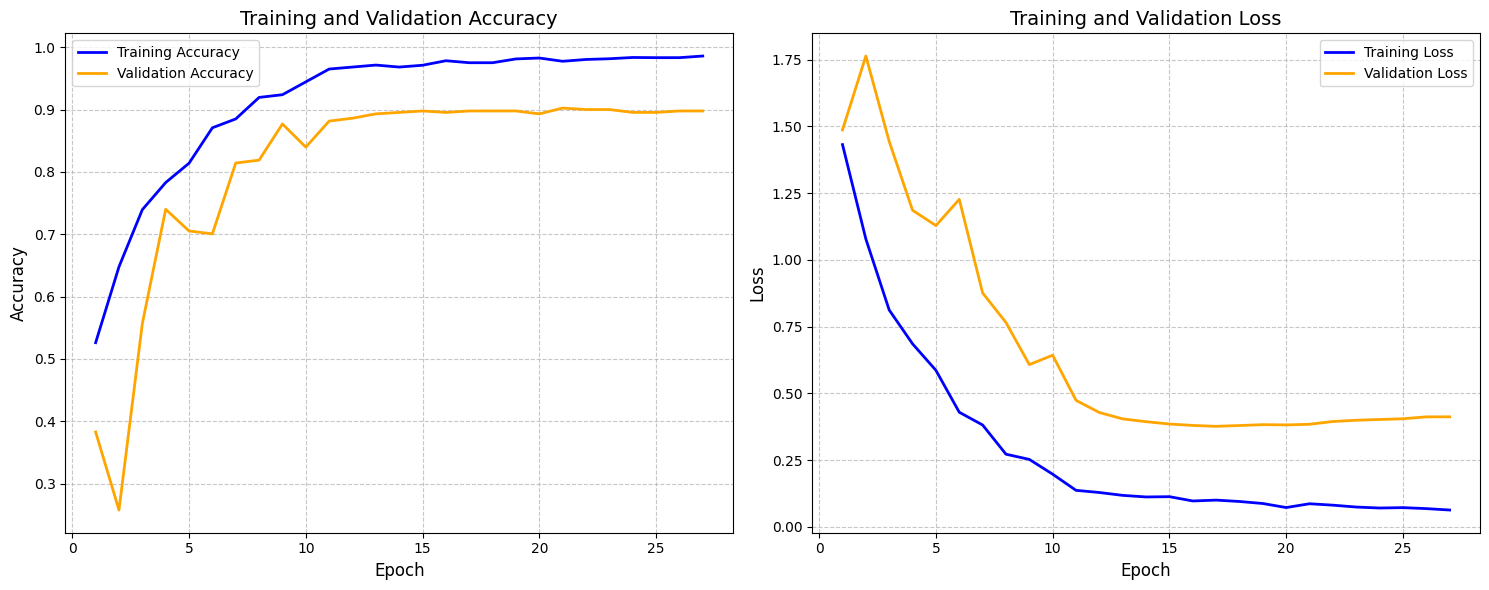

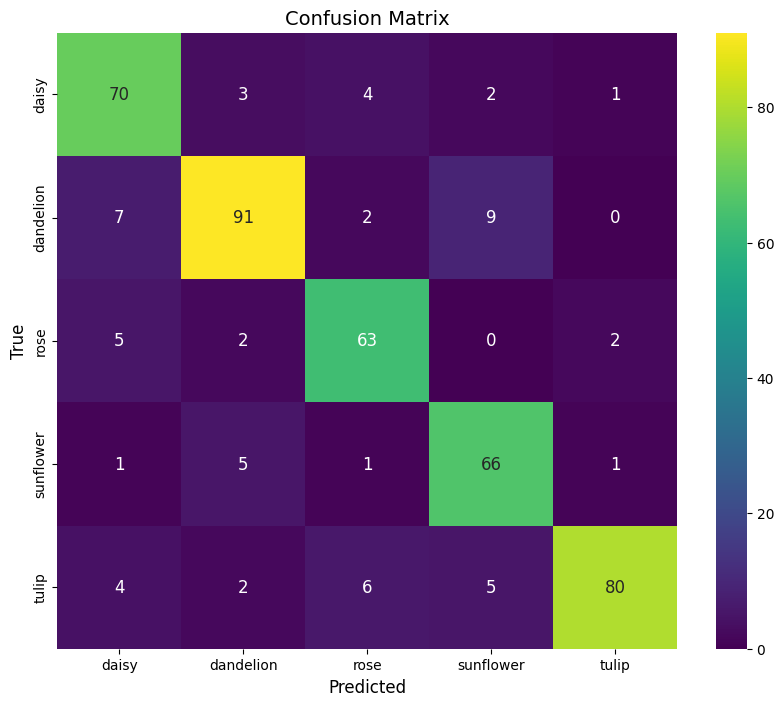

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import os

# Path (sesuaikan kalau beda, cek Cell 4 dan Cell 6)
test_dir = '/content/flowers/test'  # Dari !find output
model_path = '/content/flower_models/model_best25.keras'
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Cek file dan folder
if not os.path.exists(model_path):
    print(f"Model {model_path} nggak ada bro! Cek folder:")
    !ls /content/flower_models 2>/dev/null || echo "Folder flower_models kosong"
    !find /content -name "*.keras" 2>/dev/null
    raise FileNotFoundError(f"Model {model_path} nggak ketemu. Re-run Cell 6 (training).")

if not os.path.exists(test_dir):
    print(f"Folder test {test_dir} nggak ketemu! Coba path ini:")
    !ls /content/*/split/test 2>/dev/null || echo "Nggak ada folder test"
    !find /content -name "test" 2>/dev/null
    raise FileNotFoundError(f"Folder {test_dir} nggak ada. Cek Cell 4 (data prep).")

print("Cek isi folder test:")
!ls {test_dir}

# Load model
model = load_model(model_path)
print(f"Model loaded from {model_path}")
print("Class names:", class_names)

# Load test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, steps=int(np.ceil(test_generator.samples / 8)))
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Prediksi test set
test_generator.reset()
predictions = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / 8)))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:test_generator.samples]

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Visualisasi akurasi dan loss
try:
    history_dict = history.history
except NameError:
    print("History nggak ada bro! Re-run Cell 6 (training) atau load history.pkl")
    raise NameError("History undefined. Run Cell 6 first.")

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 6))
# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, 'orange', label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, 'orange', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12}, cbar=True)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

## Konversi Model

In [7]:
import tensorflow as tf
import os
import shutil

# Path
model_path = '/content/flower_models/model_best25.keras'
tflite_output = '/content/submission/tflite/model.tflite'
tfjs_output = '/content/submission/tfjs_model'
submission_zip = '/content/submission.zip'

# Cek model
if not os.path.exists(model_path):
    print(f"Model {model_path} nggak ada bro! Cek folder:")
    !ls /content/flower_models 2>/dev/null || echo "Folder flower_models kosong"
    !find /content -name "*.keras" 2>/dev/null
    raise FileNotFoundError(f"Model {model_path} nggak ketemu. Re-run Cell 6 (training).")

# Buat folder submission
os.makedirs('/content/submission/tflite', exist_ok=True)
os.makedirs(tfjs_output, exist_ok=True)

# Konversi ke TFLite
print("Konversi ke TFLite...")
model = tf.keras.models.load_model(model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_output, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to {tflite_output}")

# Konversi ke TensorFlow.js
print("Konversi ke TensorFlow.js...")
!pip install tensorflowjs --quiet
!tensorflowjs_converter --input_format keras {model_path} {tfjs_output}
print(f"TFJS model saved to {tfjs_output}")

# Buat readme.md dan requirements.txt
with open('/content/submission/readme.md', 'w') as f:
    f.write("# Flower Classification\nModel untuk klasifikasi 5 jenis bunga: daisy, dandelion, rose, sunflower, tulip.\nAkurasi test: ~87.50%.\n")
with open('/content/submission/requirements.txt', 'w') as f:
    f.write("tensorflow\nnumpy\nmatplotlib\nseaborn\ntensorflowjs\n")

# Bikin submission.zip
print("Bikin submission.zip...")
if os.path.exists(submission_zip):
    os.remove(submission_zip)
shutil.make_archive('/content/submission', 'zip', '/content/submission')
print(f"Submission zip created at {submission_zip}")

# Cek isi submission.zip
!ls -l {submission_zip}
!unzip -l {submission_zip}

Konversi ke TFLite...
Saved artifact at '/tmp/tmpqez3_xbu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139963710609488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710610832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710611216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710611024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710609680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710609296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710613136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710613520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710613328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963710610064: TensorSpec(shape=(), dtype=tf.resource, name=N

## Inference (Optional)

Upload gambar bunga (atau skip buat pakai sample dari test set):


Saving 12240303_80d87f77a3_n.jpg to 12240303_80d87f77a3_n.jpg

Prediksi pakai Keras model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Keras Prediction: rose (Confidence: 1.0000)

Prediksi pakai TFLite model...
TFLite Prediction: rose (Confidence: 1.0000)


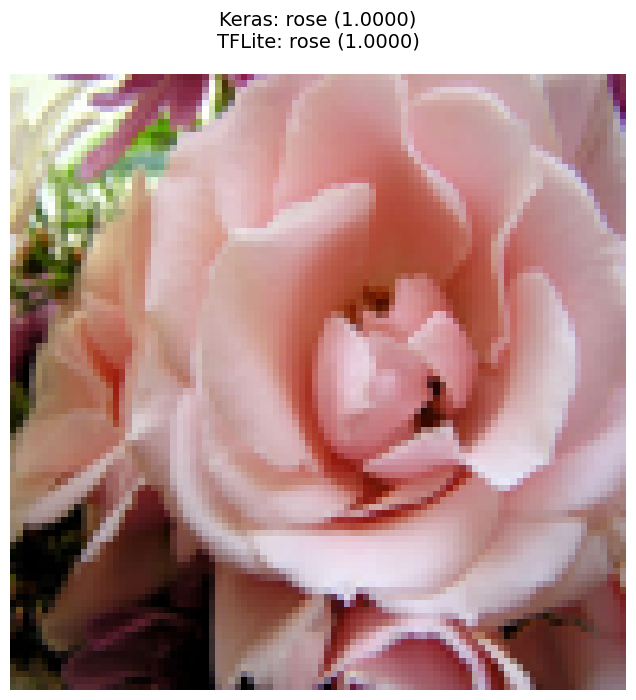

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
from PIL import Image

# Path
keras_model_path = '/content/flower_models/model_best25.keras'
tflite_model_path = '/content/submission/tflite/model.tflite'
test_dir = '/content/flowers/test'
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Cek file dan folder
if not os.path.exists(keras_model_path):
    print(f"Keras model {keras_model_path} nggak ada bro! Cek folder:")
    !ls /content/flower_models 2>/dev/null || echo "Folder flower_models kosong"
    !find /content -name "*.keras" 2>/dev/null
    raise FileNotFoundError(f"Keras model {keras_model_path} nggak ketemu. Re-run Cell 6.")

if not os.path.exists(tflite_model_path):
    print(f"TFLite model {tflite_model_path} nggak ada bro! Cek folder:")
    !ls /content/submission/tflite 2>/dev/null || echo "Folder tflite kosong"
    raise FileNotFoundError(f"TFLite model {tflite_model_path} nggak ketemu. Re-run Cell 8.")

if not os.path.exists(test_dir):
    print(f"Test folder {test_dir} nggak ketemu! Cek path:")
    !find /content -name "test" 2>/dev/null
    raise FileNotFoundError(f"Test folder {test_dir} nggak ada. Cek Cell 4.")

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(96, 96)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 96, 96, 3)
    return img_array, img

# Upload gambar atau pakai sample
print("Upload gambar bunga (atau skip buat pakai sample dari test set):")
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
else:
    # Pakai sample dari test set (misal, daisy)
    sample_dir = os.path.join(test_dir, 'daisy')
    if not os.path.exists(sample_dir):
        raise FileNotFoundError(f"Sample folder {sample_dir} nggak ada. Upload gambar.")
    image_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
    print(f"Pakai sample: {image_path}")

# Preprocess gambar
img_array, img = preprocess_image(image_path)

# Prediksi Keras
print("\nPrediksi pakai Keras model...")
keras_model = tf.keras.models.load_model(keras_model_path)
keras_pred = keras_model.predict(img_array)
keras_class = np.argmax(keras_pred, axis=1)[0]
keras_conf = np.max(keras_pred)
print(f"Keras Prediction: {class_names[keras_class]} (Confidence: {keras_conf:.4f})")

# Prediksi TFLite
print("\nPrediksi pakai TFLite model...")
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])
tflite_class = np.argmax(tflite_pred, axis=1)[0]
tflite_conf = np.max(tflite_pred)
print(f"TFLite Prediction: {class_names[tflite_class]} (Confidence: {tflite_conf:.4f})")

# Visualisasi
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Keras: {class_names[keras_class]} ({keras_conf:.4f})\nTFLite: {class_names[tflite_class]} ({tflite_conf:.4f})",
          fontsize=14, color='black', pad=20)
plt.axis('off')
plt.show()